In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib
from net.pspnet import PSPNet
import torch
import torch
import torch.nn as nn
from torchvision import transforms
from torchinfo import summary
from torchvision import datasets, models, transforms

In [8]:
model = PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, deep_features_size=512, backend='densenet').to('cuda')
model.load_state_dict(torch.load('parsing_all.pth'))
def transform_pred(pred):
    inference_transform = transforms.Compose([
            transforms.Resize((224, 224), 3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    colormap = [(0,0,0),
                (1,0.25,0), (0,0.25,0),  (0.5,0,0.25),   (1,1,1),
                (1,0.75,0), (0,0,0.5),   (0.5,0.25,0),   (0.75,0,0.25),
                (1,0,0.25), (0,0.5,0),   (0.5,0.5,0),    (0.25,0,0.5),
                (1,0,0.75), (0,0.5,0.5), (0.25,0.5,0.5), (1,0,0),
                (1,0.25,0), (0,0.75,0),  (0.5,0.75,0)]
    cmap = matplotlib.colors.ListedColormap(colormap)
    bounds=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8).reshape((224, 224, 1))
    return pred
inference_transform = transforms.Compose([
            transforms.Resize((224, 224), 3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
def denormalize(img, mean, std):
    c, _, _ = img.shape
    for idx in range(c):
        img[idx, :, :] = img[idx, :, :] * std[idx] + mean[idx]
    return img

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PSPNet (PSPNet)                               [32, 3, 224, 224]    [32, 20, 224, 224]   --                   True
├─DenseNet (feats)                            [32, 3, 224, 224]    [32, 1024, 28, 28]   --                   True
│    └─Sequential (start_features)            [32, 3, 224, 224]    [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv0)                    [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    │    └─BatchNorm2d (norm0)               [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    │    └─ReLU (relu0)                      [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    │    └─MaxPool2d (pool0)                 [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]   

In [14]:
data_dir = Path('/home/jun/HumanSemanticDataset/myLIP/val')
img_path = sorted(list(data_dir.glob('image/*.jpg')))
gt_path = sorted(list(data_dir.glob('gt/*.png')))

In [15]:
print(f'Number of sample image: {len(img_path)}, Number of gt truth images: {len(gt_path)}')

Number of sample image: 10000, Number of gt truth images: 10000


[0 1]


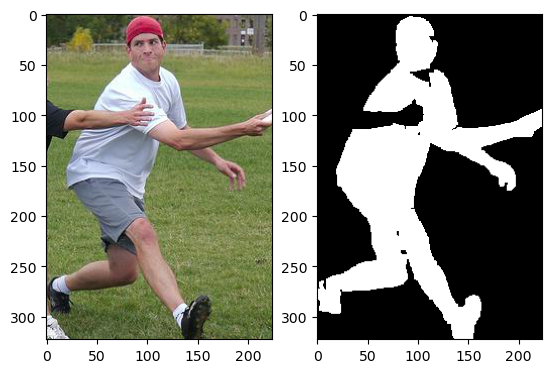

In [16]:
index = random.randrange(0, len(img_path))

img = Image.open(img_path[index]) 
img_np = np.array(img, dtype=np.uint8)
gt = Image.open(gt_path[index]).convert("L")
replace_labels = list(range(1, 20))
gt_np = np.array(gt, dtype=np.uint8)
for label in replace_labels:
    gt_np[gt_np==label] = 1
print(np.unique(gt_np))

plt.subplot(121)
plt.imshow(img_np)
plt.subplot(122)
plt.imshow(gt_np, cmap='gray')
plt.show()

torch.Size([1, 20, 224, 224])


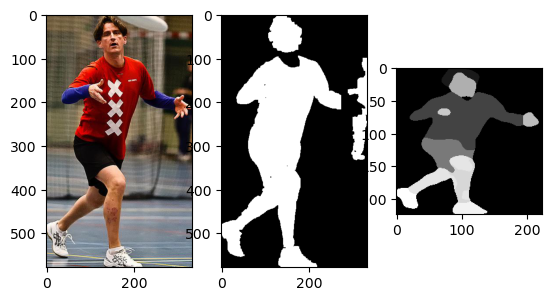

: 

In [28]:
index = random.randrange(0, len(img_path))

img = Image.open(img_path[index])
transformed_img =  inference_transform(img).unsqueeze(0).to('cuda')
img_np = np.array(img, dtype=np.uint8)
gt = Image.open(gt_path[index]).convert("L")
replace_labels = list(range(1, 20))
gt_np = np.array(gt, dtype=np.uint8)
for label in replace_labels:
    gt_np[gt_np==label] = 1
pred, _ = model(transformed_img)

print(pred.shape)
plt.subplot(131)
plt.imshow(img_np)
plt.subplot(132)
plt.imshow(gt_np, cmap='gray')
plt.subplot(133)
plt.imshow(transform_pred(pred), cmap='gray')
plt.show()

In [5]:
transform_train_list = [
            #transforms.RandomResizedCrop(size=128, scale=(0.75,1.0), ratio=(0.75,1.3333), interpolation=3), #Image.BICUBIC)
            transforms.Resize((224, 224), interpolation=3),
            transforms.ToTensor(),
            ]

transform_val_list = [
        transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
        transforms.ToTensor(),
        ]
data_transforms = {
    'train': transforms.Compose( transform_train_list ),
    'val': transforms.Compose(transform_val_list),
}
image_datasets = {}
image_datasets['train'] = datasets.ImageFolder('/home/jun/ReID_Dataset/market/dataloader/train',
                                        data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder('/home/jun/ReID_Dataset/market/dataloader/train_val/val',
                                        data_transforms['val'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                                shuffle=True, num_workers=2, pin_memory=True,
                                                prefetch_factor=2, persistent_workers=True) # 8 workers may work faster
               for x in ['train', 'val']}

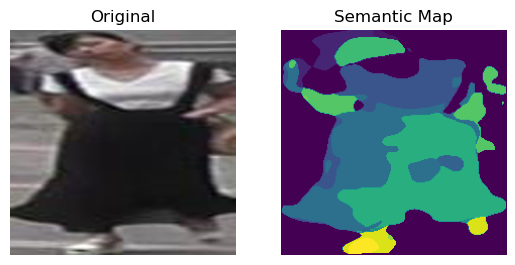

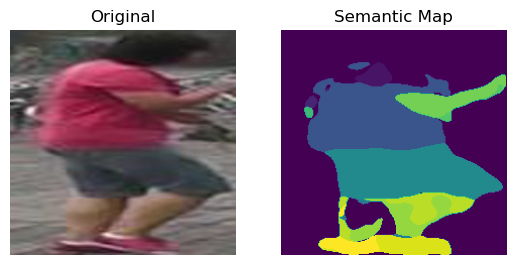

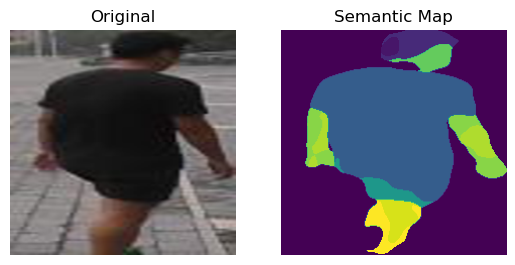

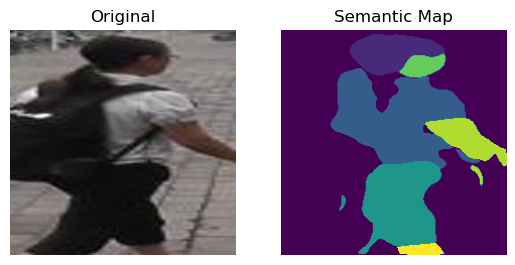

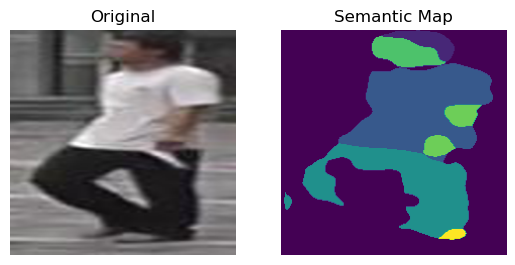

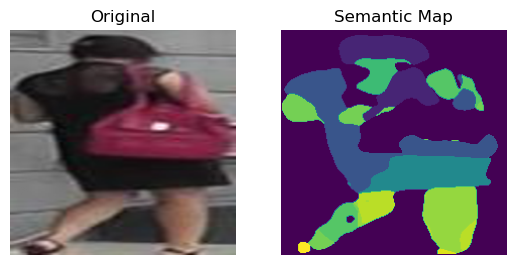

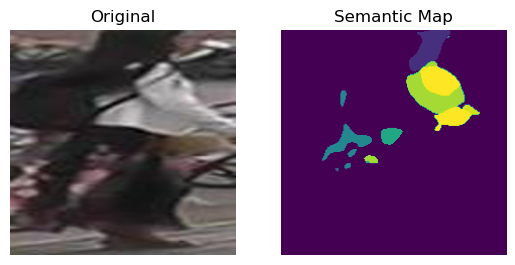

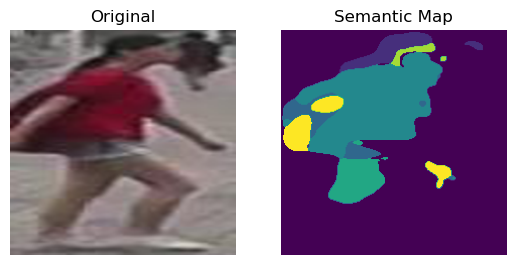

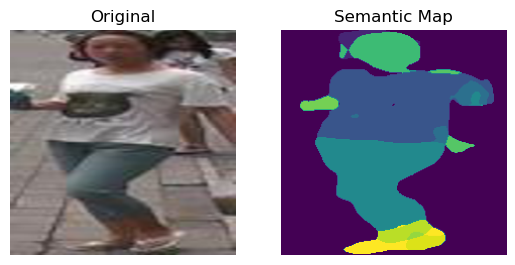

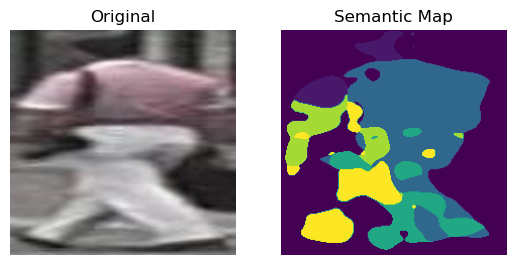

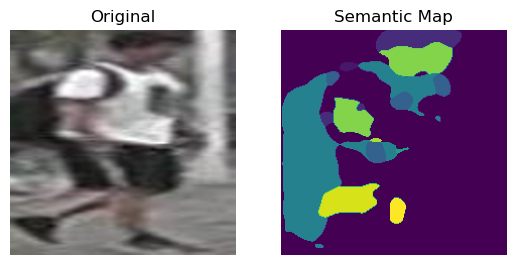

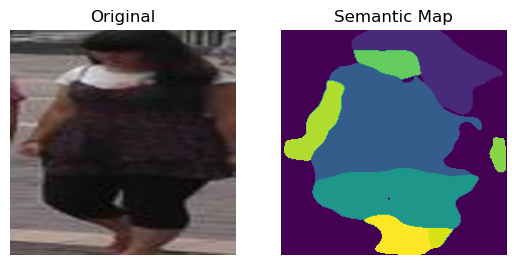

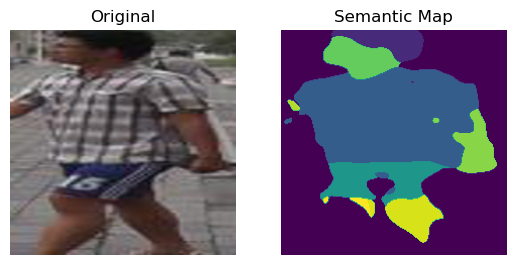

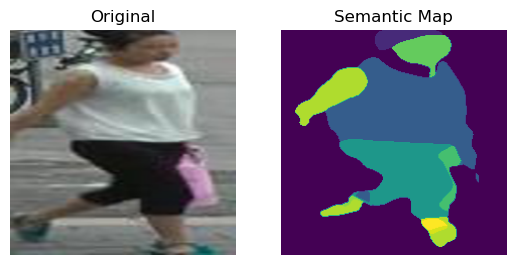

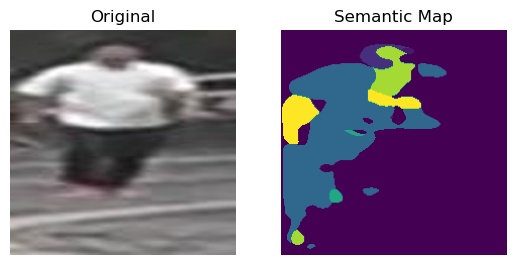

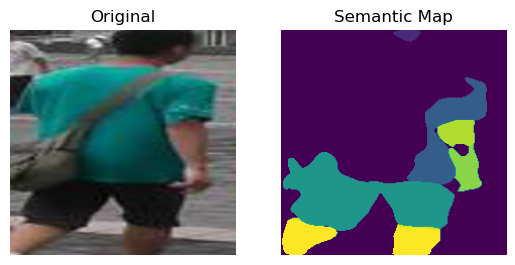

In [12]:
imgs, label = next(iter((dataloaders['val'])))
imgs = imgs.to('cuda')
preds, _ = model(imgs)
preds = preds.unsqueeze(1)
for id in range(len(preds)):
    img = imgs[id]
    #img = denormalize(img.cpu().numpy(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = img.cpu().numpy()
    img = img.transpose(1, 2, 0).reshape((224, 224, 3))
    pred = transform_pred(preds[id])
    fig, ax = plt.subplots(nrows = 1, ncols=2)
    ax[0].imshow(img)
    ax[0].set_title(f'Original')
    ax[0].axis(False)
    
    # Transform and plot target image
    ax[1].imshow(pred)
    ax[1].set_title(f'Semantic Map')
    ax[1].axis(False)